In [1]:
import pandas as pd
import numpy as np
import uuid
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

%matplotlib inline
sns.set_style("ticks")

Olist conducted an experiment to see if altering the delivery estimation could result in higher review scores.

# Generate random data for A/B testing

In [2]:
date_range = pd.date_range(start="2018-07-01", end="2018-09-01")

In [3]:
date_range

DatetimeIndex(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08',
               '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12',
               '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16',
               '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
               '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24',
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05',
               '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09',
               '2018-08-10', '2018-08-11', '2018-08-12', '2018-08-13',
               '2018-08-14', '2018-08-15', '2018-08-16', '2018-08-17',
               '2018-08-18', '2018-08-19', '2018-08-20', '2018-08-21',
               '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
      

In [4]:
np.datetime64("2018-07-15")

numpy.datetime64('2018-07-15')

In [5]:
control = {1: 10,
           2: 3,
           3: 8,
           4: 20,
           5: 59}

test = {1: 10,
        2: 2,
        3: 10,
        4: 22,
        5: 63}

def generate_review_distribution(freq_dict):
    l = []
    for key, value in freq_dict.items():
        l += [key] * value
    return l

In [6]:
def get_random_review(date, group):
    if (group == 102) & (date >= np.datetime64("2018-07-15")):
        random_reviews = generate_review_distribution(test)
    else:
        random_reviews = generate_review_distribution(control)
    return random.choice(random_reviews)
    
def generate_random_observation(date, group):
    return str(uuid.uuid4()), get_random_review(date, group)

In [7]:
# create list of dicts to later on convert to a dataframe
rows = []
for date in date_range:
    # two groups
    for group in [101,102]:
        # pick a random number of orders btw 350 and 450
        orders = random.choice(range(350,450))
        for obs in range(orders):
            order_id, review_score = generate_random_observation(date, group)
            rows.append({"date_id": date,
                         "experiment_id": group,
                         "order_id": order_id,
                         "review_score": review_score})
            
df = pd.DataFrame(rows)

### Plot data and calculate means

/Users/at/miniconda3/envs/day1/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


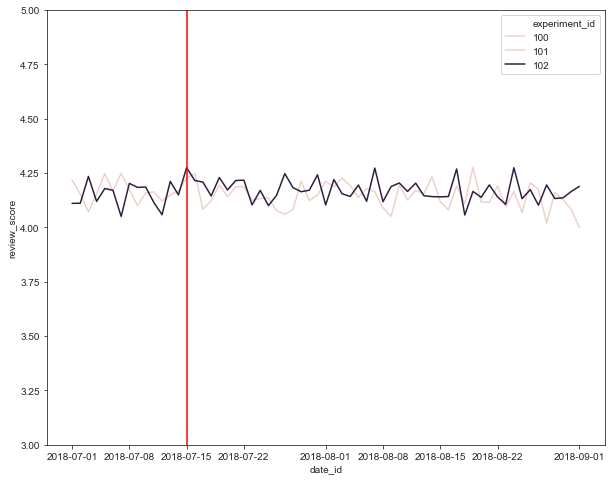

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df.groupby(["date_id", "experiment_id"]).mean().reset_index(),
             x="date_id",
             y="review_score",
             hue="experiment_id",
             ax=ax);
ax.axvline("2018-07-15", color="r")
ax.set_ylim(3,5);

In [9]:
df[df["date_id"] > "2018-07-15"].groupby("experiment_id").mean()

,review_score
experiment_id,
101,4.142714
102,4.169047


In [10]:
df.to_csv("olist_experiment_data.csv")

How do we know if this difference did not just occure by chance?
We have uncertainty because we are looking at a sample and want to generalize to all users.


We use statistics => t-test

## Central Limit Theorem

Try the exponential distribution

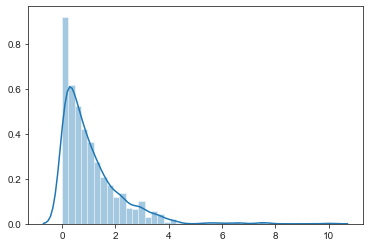

In [11]:
sns.distplot(np.random.exponential(size=1000));

In [12]:
def plot_hist(np_distr, sample_size, repetitions, ax=None, color=None):
    sample_means = [np_distr(size=sample_size).mean() for i in range(repetitions)]
    sns.distplot(sample_means, color=color, ax=ax);

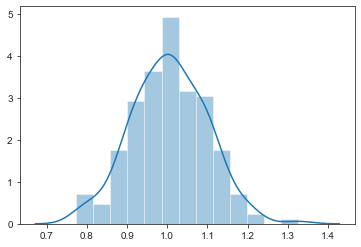

In [13]:
plot_hist(np.random.exponential, 100, 200)

Tweaking the sample size influences the shape (width)

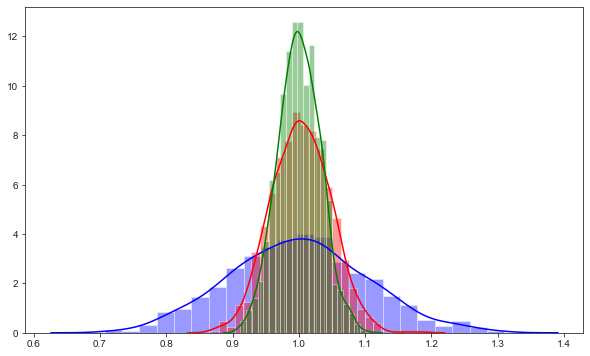

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
plot_hist(np.random.exponential, 100, 1000, ax, "b")
plot_hist(np.random.exponential, 500, 1000, ax, "r")
plot_hist(np.random.exponential, 1000, 1000, ax, "g")

Tweaking the repetitions influences how closely it resembles the normal distribution

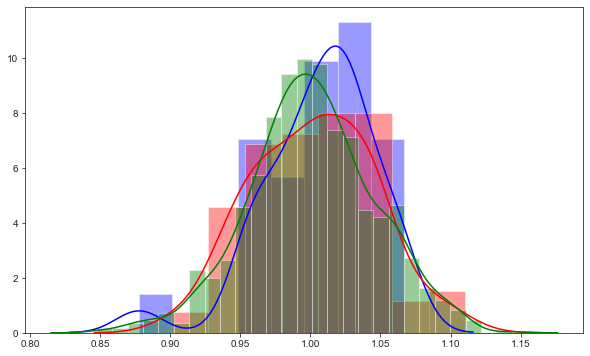

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
plot_hist(np.random.exponential, 500, 30, ax, "b")
plot_hist(np.random.exponential, 500, 100, ax, "r")
plot_hist(np.random.exponential, 500, 1000, ax, "g")

Try a different distribution. 

Poisson distribution

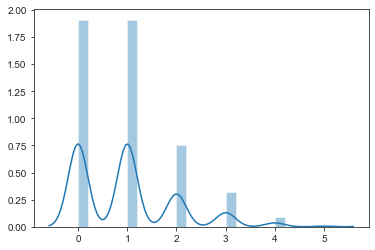

In [16]:
sns.distplot(np.random.poisson(size=1000));

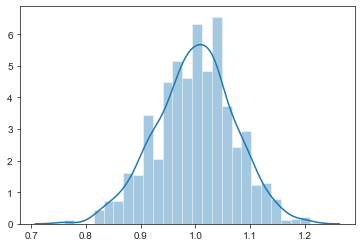

In [17]:
plot_hist(np.random.poisson, 200, 1000)

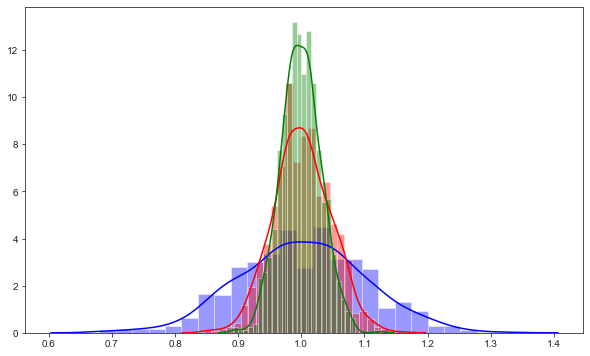

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
plot_hist(np.random.poisson, 100, 1000, ax, "b")
plot_hist(np.random.poisson, 500, 1000, ax, "r")
plot_hist(np.random.poisson, 1000, 1000, ax, "g")

## Analysis

Testing the hypothesis:

Nullhypothesis:
$$H_0: avg\_score_{control} = avg\_score_{test}$$
$$H_0: avg\_score_{control} - avg\_score_{test} = 0$$

Against the alternative hypothesis:

$$H_1: avg\_score_{control} - avg\_score_{test} \neq 0$$

-> The treatment had a non-zero impact

using t-test

In [19]:
df.dtypes

date_id          datetime64[ns]
experiment_id             int64
order_id                 object
review_score              int64
dtype: object

In [20]:
df_exp = df[df["date_id"] >= "2018-07-15"]

In [21]:
means = df_exp.groupby("experiment_id").mean()["review_score"]
means

experiment_id
101    4.14449
102    4.17126
Name: review_score, dtype: float64

In [22]:
var = df_exp.groupby("experiment_id").var()["review_score"]
var

experiment_id
101    1.676280
102    1.568604
Name: review_score, dtype: float64

In [23]:
stds = df_exp.groupby("experiment_id").std()["review_score"]
stds

experiment_id
101    1.294712
102    1.252439
Name: review_score, dtype: float64

In [24]:
ssizes = df_exp.groupby("experiment_id").size()
ssizes

experiment_id
101    19427
102    19958
dtype: int64

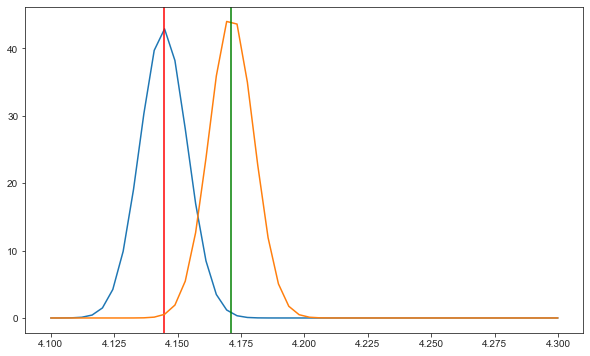

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(4.1,4.3)
std_e_a = stds[101] / np.sqrt(ssizes[101])
pdf_a = scipy.stats.norm.pdf(x,
                             means[101],
                             std_e_a)

plt.plot(x, pdf_a);
ax.axvline(means[101], color="r");

std_e_b = stds[102] / np.sqrt(ssizes[102])
pdf_b = scipy.stats.norm.pdf(x,
                             means[102],
                             std_e_b)

plt.plot(x, pdf_b);
ax.axvline(means[102], color="g");

Combining the two distributions (centering at 0)

In [26]:
combined_standard_error = np.sqrt(var[101]/ssizes[101] + var[102]/ssizes[102])
diff_mean = means[102] - means[101]

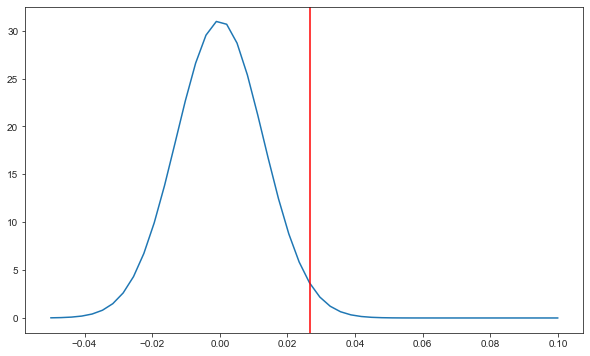

In [27]:
fig, ax = plt.subplots(figsize=(10,6))

x = np.linspace(-.05,.1)
pdf_c = scipy.stats.norm.pdf(x,
                             0,
                             combined_standard_error)

plt.plot(x, pdf_c);
ax.axvline(diff_mean, color="r");

In [28]:
t = diff_mean / combined_standard_error
t

2.0847926523138387

In [29]:
scipy.stats.ttest_ind(df_exp[df_exp["experiment_id"] == 101]["review_score"],
                      df_exp[df_exp["experiment_id"] == 102]["review_score"],
                      equal_var=False)

Ttest_indResult(statistic=-2.0847926523138374, pvalue=0.03709457460731454)